In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style = 'darkgrid')

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score,confusion_matrix, recall_score, precision_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
import imblearn
from imblearn.over_sampling import SMOTE

import warnings; warnings.simplefilter('ignore')

***
## Conditioning

We begin by loading in our cleaned data set: 

In [281]:
df = pd.read_csv('Data/Crime_data_final.csv')

In [282]:
df.head()

,Unnamed: 0,REPORT_DAT,SHIFT,METHOD,OFFENSE,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,OBJECTID,OCTO_RECORD_ID,COUNT,CITY,STATE,DATE,TIME
0,0,2018-12-22T21:10:50.000Z,EVENING,OTHERS,THEFT/OTHER,4,4.0,Cluster 18,002301 2,2301.0,Precinct 45,38.942182,-77.014557,329684676,18217166-01,1,"Washington, DC",District of Columbia,2018-12-22,21:10:50
1,1,2018-12-22T20:29:36.000Z,EVENING,OTHERS,THEFT/OTHER,6,1.0,Cluster 27,007200 2,7200.0,Precinct 131,38.876999,-77.004356,329684677,18217171-01,1,"Washington, DC",District of Columbia,2018-12-22,20:29:36
2,2,2018-12-23T03:38:37.000Z,MIDNIGHT,OTHERS,THEFT/OTHER,7,6.0,Cluster 32,009603 3,9603.0,Precinct 102,38.890214,-76.952775,329684678,18217172-01,1,"Washington, DC",District of Columbia,2018-12-23,03:38:37
3,3,2018-12-22T21:00:57.000Z,EVENING,OTHERS,MOTOR VEHICLE THEFT,7,6.0,Cluster 33,007803 3,7803.0,Precinct 98,38.890241,-76.935370,329684679,18217180-01,1,"Washington, DC",District of Columbia,2018-12-22,21:00:57
4,4,2018-12-22T20:49:59.000Z,EVENING,OTHERS,THEFT F/AUTO,2,1.0,Cluster 8,005800 2,5800.0,Precinct 129,38.900860,-77.020912,329684680,18217182-01,1,"Washington, DC",District of Columbia,2018-12-22,20:49:59


And drop the unnecessary columns: 

In [283]:
df = df.drop(columns = ['Unnamed: 0', 'COUNT', 'CITY', 'STATE', 'REPORT_DAT', 'OCTO_RECORD_ID', 'OBJECTID'])

Next we split our feature and label data:

In [284]:
y = df.OFFENSE
df = df.drop(columns = 'OFFENSE')

Some of our feature variables include text data. We'll need to split these columns and include only the integer values:

In [285]:
df['NEIGHBORHOOD_CLUSTER'] = df['NEIGHBORHOOD_CLUSTER'].str.split(' ').str[1]
df['VOTING_PRECINCT'] = df['VOTING_PRECINCT'].str.split(' ').str[1]

Further, we'll isolate our date and time features by their component parts (i.e., day, month, year):

In [286]:
df['YEAR'] = df['DATE'].str.split('-').str[0]
df['MONTH'] = df['DATE'].str.split('-').str[1]
df['DAY'] = df['DATE'].str.split('-').str[2]

df['HOUR'] = df['TIME'].str.split(':').str[0]
df['MINUTE'] = df['TIME'].str.split(':').str[1]
df['SECOND'] = df['TIME'].str.split(':').str[2]

In [287]:
df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND']].head()

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND
0,2018,12,22,21,10,50
1,2018,12,22,20,29,36
2,2018,12,23,03,38,37
3,2018,12,22,21,00,57
4,2018,12,22,20,49,59


In [288]:
df = df.drop(columns = ['DATE', 'TIME'])

In order to keep the 'BLOCK_GROUP' data, we'll need to remove the space included within the data: 

In [289]:
df['BLOCK_GROUP'] = df['BLOCK_GROUP'].str.replace(" ","")

And convert the string (object) variables to integers:

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53654 entries, 0 to 53653
Data columns (total 16 columns):
SHIFT                   53654 non-null object
METHOD                  53654 non-null object
WARD                    53654 non-null int64
DISTRICT                53654 non-null float64
NEIGHBORHOOD_CLUSTER    53654 non-null object
BLOCK_GROUP             53654 non-null object
CENSUS_TRACT            53654 non-null float64
VOTING_PRECINCT         53654 non-null object
LATITUDE                53654 non-null float64
LONGITUDE               53654 non-null float64
YEAR                    53654 non-null object
MONTH                   53654 non-null object
DAY                     53654 non-null object
HOUR                    53654 non-null object
MINUTE                  53654 non-null object
SECOND                  53654 non-null object
dtypes: float64(4), int64(1), object(11)
memory usage: 6.5+ MB


In [291]:
df['DISTRICT'] = df['DISTRICT'].astype(int)
df['NEIGHBORHOOD_CLUSTER'] = df['NEIGHBORHOOD_CLUSTER'].astype(int)
df['BLOCK_GROUP'] = df['BLOCK_GROUP'].astype(int)
df['VOTING_PRECINCT'] = df['VOTING_PRECINCT'].astype(int)
df['DISTRICT'] = df['DISTRICT'].astype(int)

df['YEAR'] = df['YEAR'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)
df['DAY'] = df['DAY'].astype(int)

df['HOUR'] = df['HOUR'].astype(int)
df['MINUTE'] = df['MINUTE'].astype(int)
df['SECOND'] = df['SECOND'].astype(int)

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53654 entries, 0 to 53653
Data columns (total 16 columns):
SHIFT                   53654 non-null object
METHOD                  53654 non-null object
WARD                    53654 non-null int64
DISTRICT                53654 non-null int64
NEIGHBORHOOD_CLUSTER    53654 non-null int64
BLOCK_GROUP             53654 non-null int64
CENSUS_TRACT            53654 non-null float64
VOTING_PRECINCT         53654 non-null int64
LATITUDE                53654 non-null float64
LONGITUDE               53654 non-null float64
YEAR                    53654 non-null int64
MONTH                   53654 non-null int64
DAY                     53654 non-null int64
HOUR                    53654 non-null int64
MINUTE                  53654 non-null int64
SECOND                  53654 non-null int64
dtypes: float64(3), int64(11), object(2)
memory usage: 6.5+ MB


***
## Feature Engineering

The first piece of our feature engineering phase requires us to address the categorical features from the 'shift' and 'method' columns. We'll address this by dummifying the columns:

In [293]:
display(df.SHIFT.unique())
display(df.METHOD.unique())

array(['EVENING', 'MIDNIGHT', 'DAY'], dtype=object)

array(['OTHERS', 'GUN', 'KNIFE'], dtype=object)

In [294]:
df = pd.get_dummies(df)

In [295]:
print('Final feature dataset shape:',df.shape)
print()
display(df.head())

Final feature dataset shape: (53654, 20)



,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,SHIFT_DAY,SHIFT_EVENING,SHIFT_MIDNIGHT,METHOD_GUN,METHOD_KNIFE,METHOD_OTHERS
0,4,4,18,23012,2301.0,45,38.942182,-77.014557,2018,12,22,21,10,50,0,1,0,0,0,1
1,6,1,27,72002,7200.0,131,38.876999,-77.004356,2018,12,22,20,29,36,0,1,0,0,0,1
2,7,6,32,96033,9603.0,102,38.890214,-76.952775,2018,12,23,3,38,37,0,0,1,0,0,1
3,7,6,33,78033,7803.0,98,38.890241,-76.935370,2018,12,22,21,0,57,0,1,0,0,0,1
4,2,1,8,58002,5800.0,129,38.900860,-77.020912,2018,12,22,20,49,59,0,1,0,0,0,1


We're going to save the dataframe in its current form for later use with testing our model:

In [296]:
df['TARGET'] = y

df.to_csv('Data/unbalanced_unscaled_modeling_data.csv')

Next we address our label data. We start by taking a look at the distribution of our labels to determine whether or not we'll need to rebalance the dataset: 

In [297]:
print('Number of offense categories:', y.nunique())
print()
print('Frequency of each offense category:')
print()
print(y.value_counts())

Number of offense categories: 9

Frequency of each offense category:

THEFT/OTHER                   23219
THEFT F/AUTO                  17917
MOTOR VEHICLE THEFT            3695
ROBBERY                        3319
ASSAULT W/DANGEROUS WEAPON     2634
BURGLARY                       2210
SEX ABUSE                       389
HOMICIDE                        261
ARSON                            10
Name: OFFENSE, dtype: int64


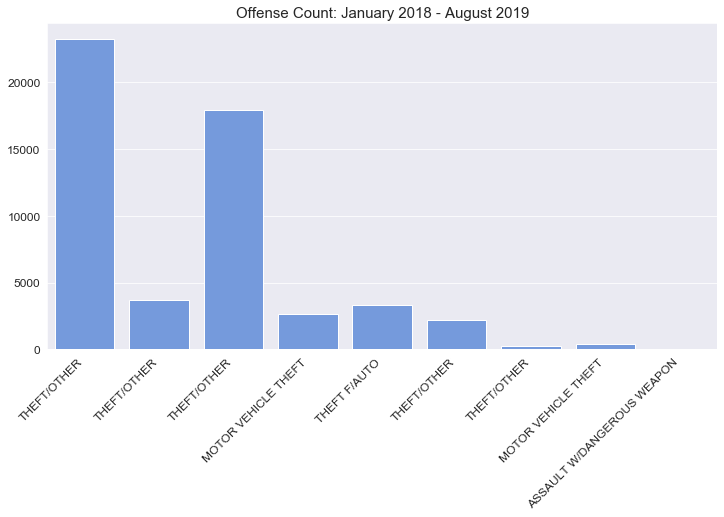

In [298]:
sns.set_style('darkgrid')

plt.figure(figsize= (12,6))

g = sns.countplot(x = y, color = 'cornflowerblue')
g.set_xticklabels(rotation = 45, labels = y, horizontalalignment='right')

plt.title('Offense Count: January 2018 - August 2019', size = 15)
plt.ylabel('')
plt.xlabel('')
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

Based on the extreme imbalance of our target variable, we'll need to employ some rebalancing using the SMOTE method. Before doing so, let's convert our target variable to integers:

In [299]:
y = y.astype('category')
encoded_labels = y.cat.codes
encoded_labels.head()

0    8
1    8
2    8
3    4
4    7
dtype: int8

I generated a label key that maps the coded labels with the string labels for later model evaluation purposes:

In [300]:
str_labels = df['TARGET']
int_labels = encoded_labels

In [301]:
label_key = pd.concat([str_labels, int_labels], axis = 1)

In [302]:
label_key['INT_TARGET'] = label_key[0]
label_key.drop(columns = 0, inplace = True)
label_key.head()

,TARGET,INT_TARGET
0,THEFT/OTHER,8
1,THEFT/OTHER,8
2,THEFT/OTHER,8
3,MOTOR VEHICLE THEFT,4
4,THEFT F/AUTO,7


With our labels encoded, we can move on to rebalancing the dataset: 

In [269]:
y = encoded_labels
df.drop(columns = 'TARGET', inplace = True)
x = df

In [270]:
print('Target value counts pre resampling:')
print(y.value_counts())
print()

x_resampled, y_resampled = SMOTE().fit_sample(x,y)

print('Target value counts post resampling:')
print(pd.Series(y_resampled).value_counts())

resampled_feats = pd.DataFrame(x_resampled, columns = df.columns)
target = y_resampled

Target value counts pre resampling:
8    23219
7    17917
4     3695
5     3319
1     2634
2     2210
6      389
3      261
0       10
dtype: int64

Target value counts post resampling:
8    23219
7    23219
6    23219
5    23219
4    23219
3    23219
2    23219
1    23219
0    23219
dtype: int64


Let's confirm our feature and target set are of the same length after our resampling:

In [ ]:
print('Number of instances in our feature set:', len(resampled_feats))
print('Number of labels in our target set:', len(target))

As a last step in the feature engineering phase, we'll employ the Standard Scaler function from SKlearn to achieve a uniform scale of our data. We'll do this to avoid outsized impacts certain features may have on our classification models:

In [ ]:
column_names = resampled_feats.columns

scaler = StandardScaler()
scaled_feats = scaler.fit_transform(resampled_feats)

scaled_feats = pd.DataFrame(scaled_feats, columns = column_names)

features = scaled_feats
features.head()

Before finishing this section, we're going to combine our features and target data in one dataframe and save the file as a CSV for easy when running our classifiers down:

In [ ]:
features['TARGET'] = target
modeling_df = features

In [52]:
modeling_df.to_csv('Data/Modeling_data_final.csv')

## Modeling

With the data prepped for modeling, we'll load in the modeling data, split our target and features, and split our train and test set:

In [442]:
df = pd.read_csv('Data/Modeling_data_final.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
features = df.drop(columns = ['TARGET'])
target = df.TARGET

In [443]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .20)

We're going to run a few classifier algorithms and assess the best performer based on the average accuracy score using KFold cross validation:

In [6]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('ADB', AdaBoostClassifier()))

seed = 42
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    
    kfold = model_selection.KFold(n_splits = 20, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    print(msg)

KNN: 0.788349 (0.003473)
DT: 0.768621 (0.002915)
NB: 0.418320 (0.004928)
RF: 0.833708 (0.003683)
ADB: 0.331812 (0.022362)


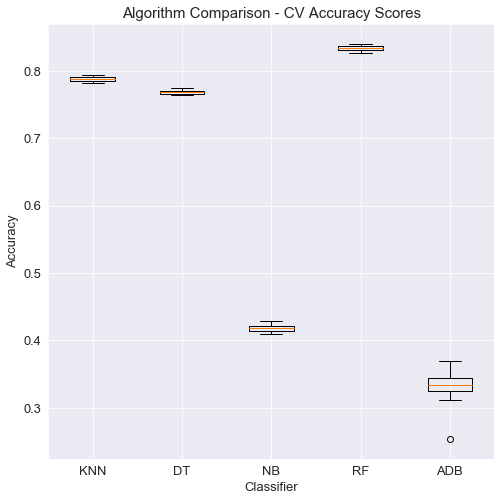

In [20]:
plt.figure(figsize=(8,8))

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison - CV Accuracy Scores', size = 15)

plt.xlabel('Classifier', size = 13)
plt.ylabel('Accuracy', size = 13)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

Based on the above results, it's clear the random forest algorithm yields the best results with respect to accuracy scores. Our next step is to run a grid search using varying random forest hyper parameters in an attempt to flush out the best final model: 

In [38]:
param_grid = { 
    'n_estimators': [50, 100, 150],
    'max_depth' : [5, 15, 30],
    'min_samples_leaf' : [1, 5, 10],
    'criterion' : ['gini', 'entropy']
}

In [ ]:
rfc = RandomForestClassifier(random_state = 42)

CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3)
CV_rfc.fit(X_train, y_train)

In [ ]:
print('Optimal hyperparameters for max accuracy score:', CV_rfc.best_params_)

With the retrieval of the best parameters, let's re-run the algorithm and test the model against our testing set: 

In [444]:
rfc = RandomForestClassifier(random_state = 42, criterion = 'gini', max_depth = 30, 
                             min_samples_leaf = 1, n_estimators = 150, verbose = 0)

trained_model = rfc.fit(X_train, y_train)

**Model One Evaluation**

With our trained model, we'll make predictions using the feature test set and compare it to the actual labels using the target test set:

In [445]:
predictions = trained_model.predict(X_test)

print('Random Forest model accuracy: ', accuracy_score(y_test, predictions))

Random Forest model accuracy:  0.8694819954540016


With our model predictions assessed against our actual labels, we'll take a look at the confusion matrix produced by our models predictions: 

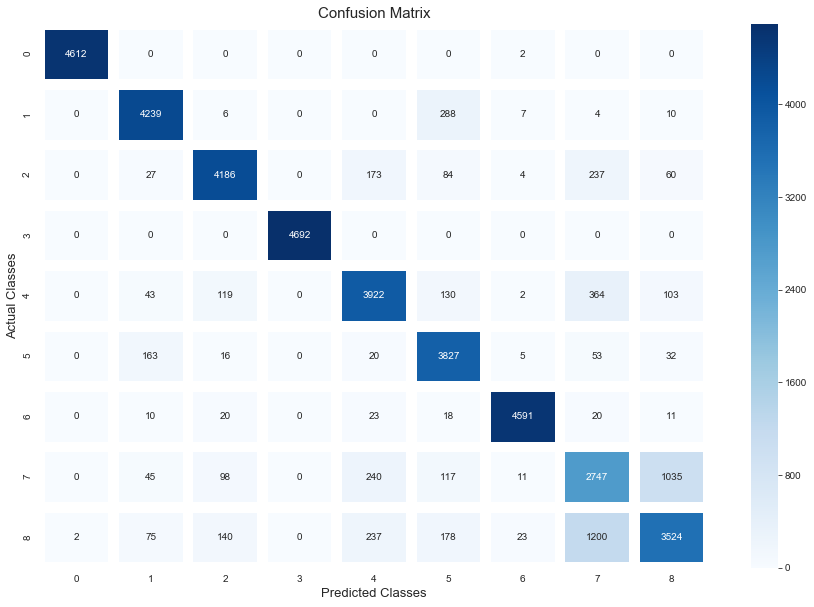

In [446]:
cnf_matrix = confusion_matrix(predictions, y_test)

plt.figure(figsize=(15,10))
sns.heatmap(cnf_matrix, annot = True, fmt = 'd', cmap= 'Blues', linewidths=10, )
plt.title('Confusion Matrix', size= 15)
plt.xlabel('Predicted Classes', size = 13)
plt.ylabel('Actual Classes', size = 13)

plt.show()

With our modeled assessed for accuracy, we'll step back and look at the features of most importance in determining the type of crime that took place:

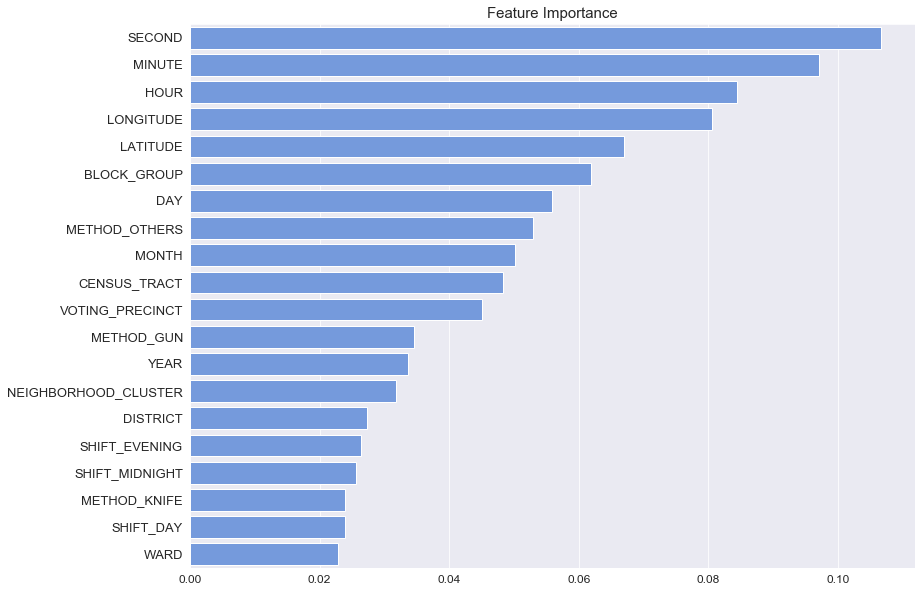

In [447]:
feature_importances = pd.Series(trained_model.feature_importances_, 
                                index = features.columns).sort_values(ascending = False)

plt.figure(figsize=(13,10))

sns.barplot(x = feature_importances, y = feature_importances.index, color = 'cornflowerblue')
plt.title('Feature Importance', size = 15)
plt.yticks(size = 13)
plt.xticks(size = 12)
plt.show()

**Principal Component Analysis** 

Out of curiosity, I decided compress the number of dimensions from 21 to 2 using Principal Component Analysis in order to visualize our feature data in a two dimensional space. Doing so might assist us in conceptualizing the algorithms ability to group our classes within the vector space:

In [170]:
df = pd.read_csv('Data/Modeling_data_final.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
features = df.drop(columns = ['TARGET'])
target = df.TARGET

In [23]:
pca = PCA(n_components = 2)

principal_components = pca.fit_transform(features)

principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])

In [24]:
pca_df = pd.concat([principal_df, target], axis = 1)
pca_df.head()

,principal component 1,principal component 2,TARGET
0,2.663616,-0.924847,8
1,0.079881,-1.979377,8
2,-2.283466,0.226935,8
3,-1.476007,-2.264453,4
4,2.223107,-1.919224,7


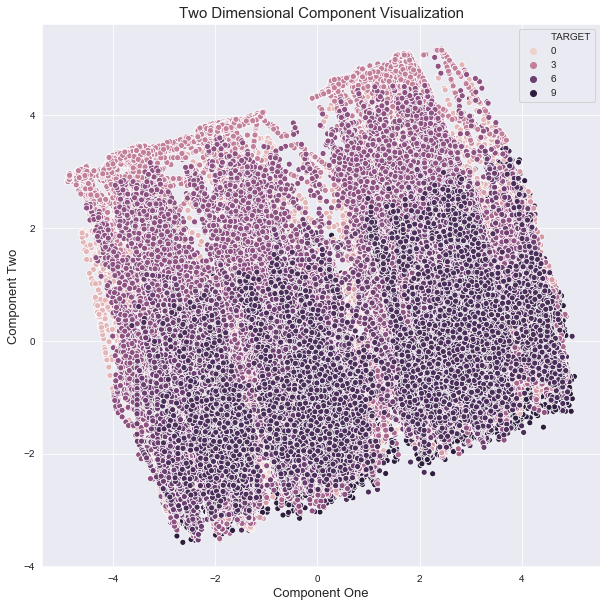

In [25]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'principal component 1', y = 'principal component 2', hue = 'TARGET', data = pca_df)
plt.title('Two Dimensional Component Visualization', size = (15))
plt.xlabel('Component One', size = 13)
plt.ylabel('Component Two', size = 13)
plt.show()

Though difficult for us to interpret, the plot above does display a level of gradient transition the further positive we are with respect to component two. 

**Model Two**

Although the second and minute data appear most important, we're going to run our random forest classifier once more without these features. The time reported on crime data could be subject to human influence, et cetera, as such granular data about the exact timing of a crime is likely subject to error.

We'll start by removing the minute and second features:

In [448]:
X_train.drop(columns = ['SECOND', 'MINUTE'], inplace = True)
X_test.drop(columns = ['SECOND', 'MINUTE'], inplace = True)

In [449]:
rfc_2 = RandomForestClassifier(random_state = 42, criterion = 'gini', max_depth = 30, 
                             min_samples_leaf = 1, n_estimators = 150, verbose = 0)

trained_model_2 = rfc_2.fit(X_train, y_train)
predictions_2 = trained_model_2.predict(X_test)

print('Random Forest model accuracy sans minute and second features: ', accuracy_score(y_test, predictions_2))

Random Forest model accuracy sans minute and second features:  0.8443115205168082


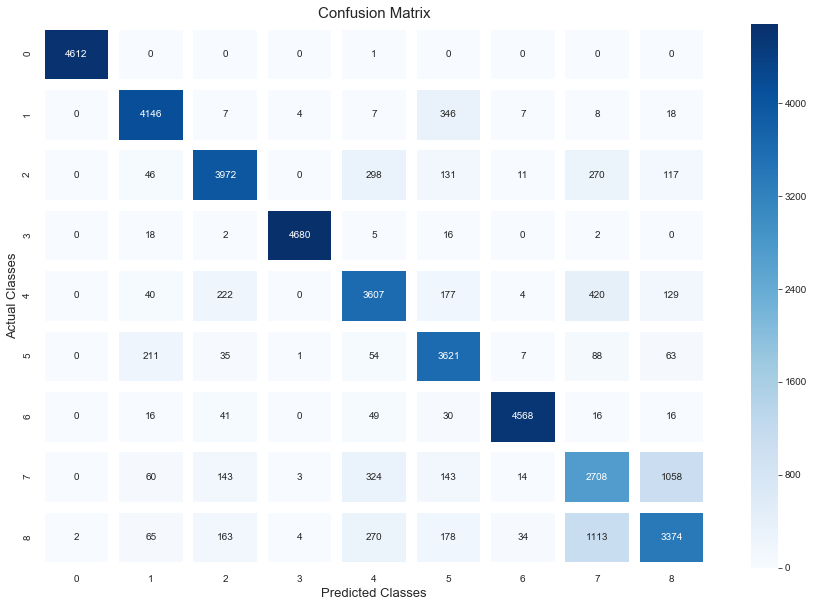

In [450]:
cnf_matrix = confusion_matrix(predictions_2, y_test)

plt.figure(figsize=(15,10))
sns.heatmap(cnf_matrix, annot = True, fmt = 'd', cmap= 'Blues', linewidths=10, )
plt.title('Confusion Matrix', size= 15)
plt.xlabel('Predicted Classes', size = 13)
plt.ylabel('Actual Classes', size = 13)

plt.show()

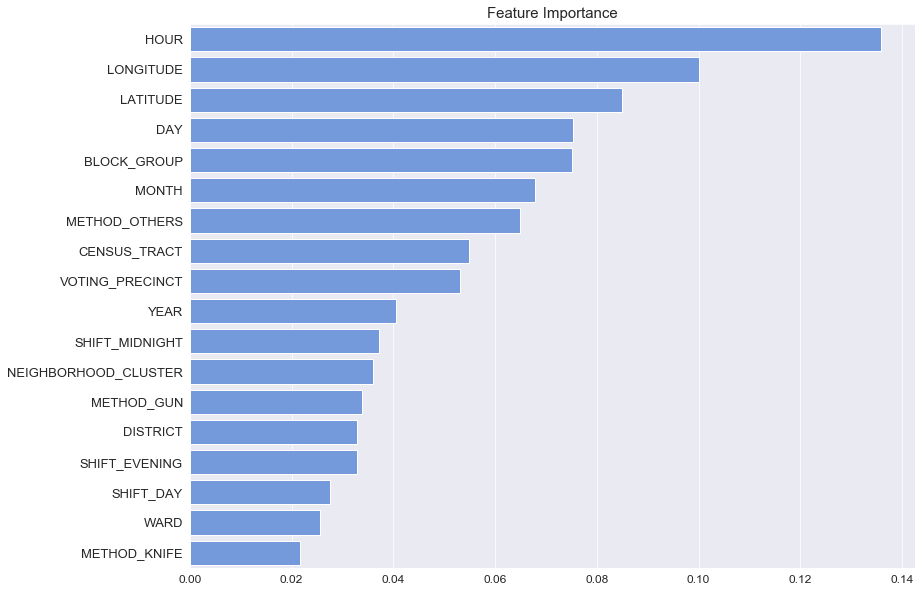

In [451]:
feature_importances_2 = pd.Series(trained_model_2.feature_importances_, 
                                index = X_train.columns).sort_values(ascending = False)

plt.figure(figsize=(13,10))

sns.barplot(x = feature_importances_2, y = feature_importances_2.index, color = 'cornflowerblue')
plt.title('Feature Importance', size = 15)
plt.yticks(size = 13)
plt.xticks(size = 12)
plt.show()

**Confusion Matrix Analysis**

We're spend some time looking into a few of the misclassifications in an attempt to understand why the underlying data is causing confusion within our matrix. 

We'll begin by investigating the distribution of 'HOUR' feature of classes 7 & 8 against classes 1 & 3: 

In [452]:
label_key_grouped = label_key.groupby('TARGET').mean()
label_key_grouped

,INT_TARGET
TARGET,
ARSON,0
ASSAULT W/DANGEROUS WEAPON,1
BURGLARY,2
HOMICIDE,3
MOTOR VEHICLE THEFT,4
ROBBERY,5
SEX ABUSE,6
THEFT F/AUTO,7
THEFT/OTHER,8


In [453]:
label_key['TARGET'].value_counts()


THEFT/OTHER                   23219
THEFT F/AUTO                  17917
MOTOR VEHICLE THEFT            3695
ROBBERY                        3319
ASSAULT W/DANGEROUS WEAPON     2634
BURGLARY                       2210
SEX ABUSE                       389
HOMICIDE                        261
ARSON                            10
Name: TARGET, dtype: int64

We'll isolate the target variables in their own dataset for individual review of the distributions of key features. Doing so will help identify why, perhaps, our model is struggling to correctly classify some of the target: 

In [319]:
df_0 = df[(df['TARGET'] == 0)]
df_1 = df[(df['TARGET'] == 1)]
df_3 = df[(df['TARGET'] == 3)]
df_4 = df[(df['TARGET'] == 4)]
df_5 = df[(df['TARGET'] == 5)]
df_7 = df[(df['TARGET'] == 7)]
df_8 = df[(df['TARGET'] == 8)]

In [328]:
x1_h = df_1['HOUR']
x4_h = df_4['HOUR']
x7_h = df_7['HOUR']
x8_h = df_8['HOUR']

With the hour feature providing the most signal in our model, we'll take a look at the isolated distribution of the hour data for a the target variables 7 & 8. The intent is to investigate whether of not this feature is causing confusion among the two closely related crimes: 

In [441]:
bins = np.linspace(-2,2,50)

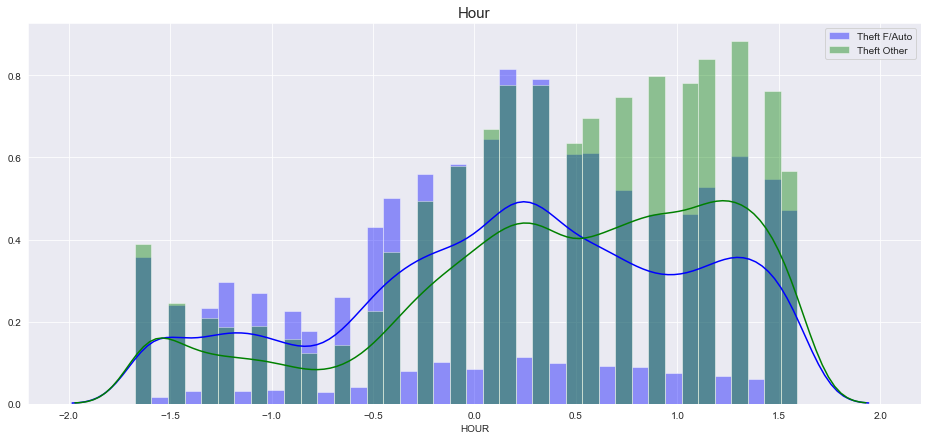

None

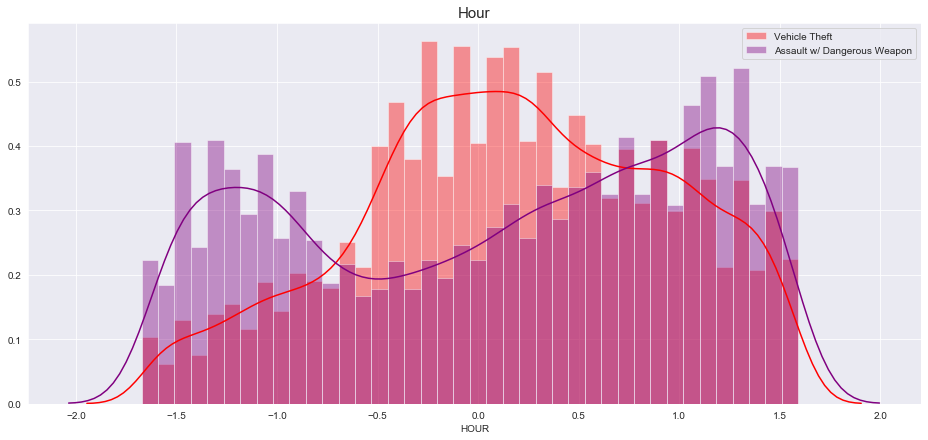

None

In [482]:
plt.figure(figsize=(16,7))

sns.distplot(x7_h, kde = True, label = 'Theft F/Auto', color = 'blue', bins = bins),
sns.distplot(x8_h, kde = True, label = 'Theft Other', color = 'green', bins = bins)

plt.legend()
plt.title('Hour', size = 15)

display(plt.show())


plt.figure(figsize=(16,7))

sns.distplot(x4_h, kde = True, label = 'Vehicle Theft', color = 'red', bins = bins),
sns.distplot(x1_h, kde = True, label = 'Assault w/ Dangerous Weapon', color = 'purple', bins = bins)

plt.legend()
plt.title('Hour', size = 15)

display(plt.show())

We'll do the same for geo location data (longitude & latitude):

In [360]:
x1_lon = df_1['LONGITUDE']
x4_lon = df_4['LONGITUDE']
x7_lon = df_7['LONGITUDE']
x8_lon = df_8['LONGITUDE']

x1_lat = df_1['LATITUDE']
x4_lat = df_4['LATITUDE']
x7_lat = df_7['LATITUDE']
x8_lat = df_8['LATITUDE']

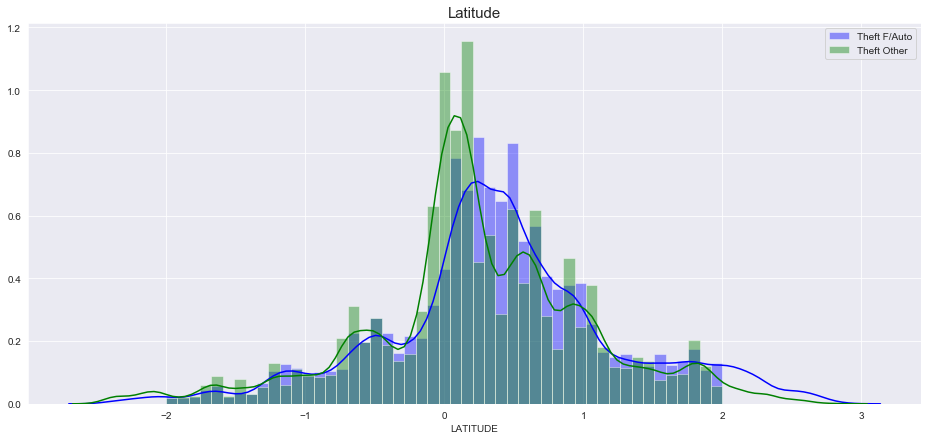

None

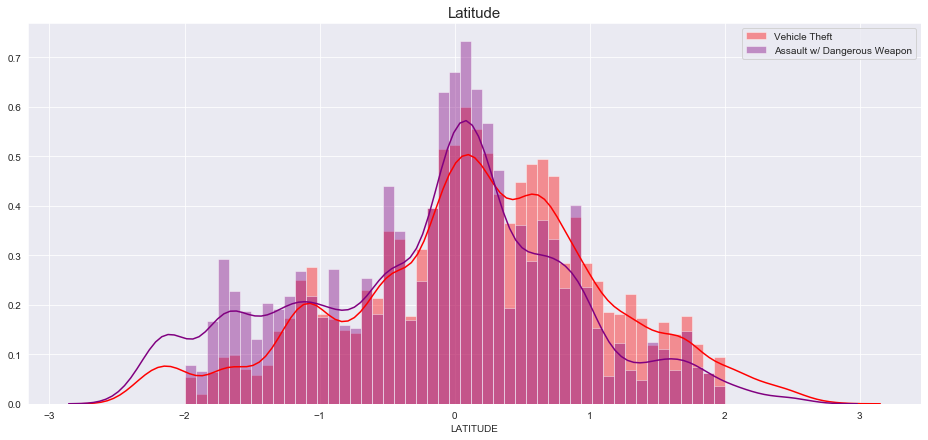

None

In [483]:
plt.figure(figsize=(16,7))

sns.distplot(x7_lat, kde = True, label = 'Theft F/Auto', color = 'blue', bins = bins)
sns.distplot(x8_lat, kde = True, label = 'Theft Other', color = 'green', bins = bins)
plt.title('Latitude', size = 15)
plt.legend()

display(plt.show())


plt.figure(figsize=(16,7))

sns.distplot(x4_lat, kde = True, label = 'Vehicle Theft', color = 'red', bins = bins)
sns.distplot(x1_lat, kde = True, label = 'Assault w/ Dangerous Weapon', color = 'purple', bins = bins)
plt.legend()
plt.title('Latitude', size = 15)

display(plt.show())

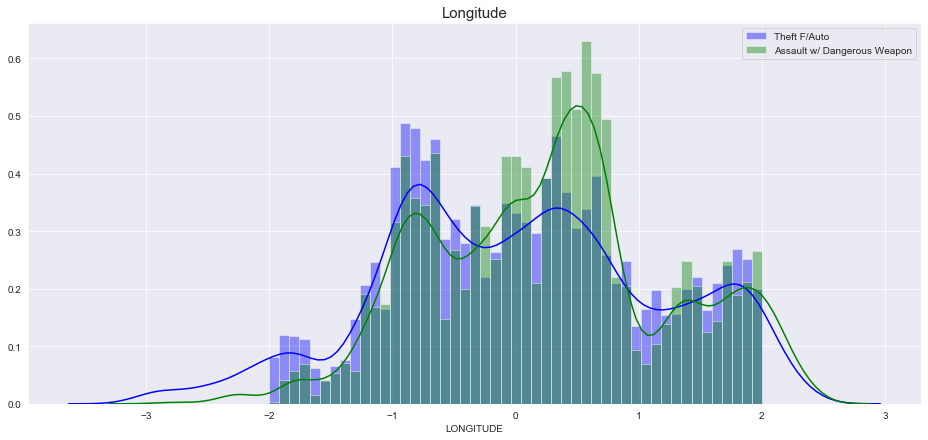

None

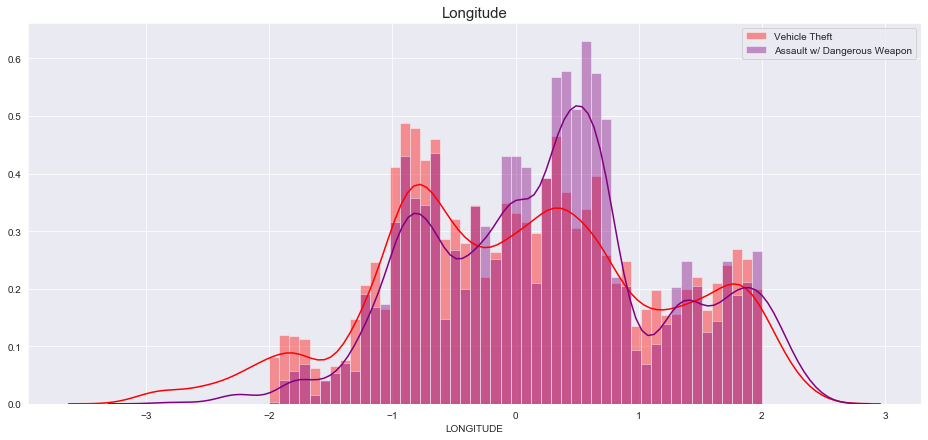

None

In [484]:
plt.figure(figsize=(16,7))

sns.distplot(x4_lon, kde = True, label = 'Theft F/Auto', color = 'blue', bins = bins)
sns.distplot(x1_lon, kde = True, label = 'Assault w/ Dangerous Weapon', color = 'green', bins = bins)
plt.title('Longitude', size = 15)
plt.legend()

display(plt.show())


plt.figure(figsize=(16,7))

sns.distplot(x4_lon, kde = True, label = 'Vehicle Theft', color = 'red', bins = bins)
sns.distplot(x1_lon, kde = True, label = 'Assault w/ Dangerous Weapon', color = 'purple', bins = bins)
plt.legend()
plt.title('Longitude', size = 15)

display(plt.show())

Based on the analysis above, it seems geographic location data behaves similarly for both the minor theft crimes vs. vehicle theft and assault. 

That said, the hour feature, also the feature with the most signal (importance), shows a great deal of similarity between the minor theft crimes compared to vehicle theft and assault. This may be one reason why our model is struggling with differentiating between the two minor theft crimes. 

Because the minor theft crimes appear similar in their feature (hour) makeup, we're going to combine these class labels in an attempt to further improve our models accuracy score:

In [486]:
df = pd.read_csv('Data/Modeling_data_final.csv')
df.drop(columns = ['Unnamed: 0','SECOND', 'MINUTE'], inplace = True)

In [487]:
TARGET_2 = []

for i in df['TARGET']:
    if i == 8:
        x = i - 1
        TARGET_2.append(x)
    else:
        TARGET_2.append(i)

We'll ensure the reclassification of class 8 was performed correctly:

In [488]:
df['TARGET_2'] = TARGET_2
df[['TARGET', 'TARGET_2']].head()

,TARGET,TARGET_2
0,8,7
1,8,7
2,8,7
3,4,4
4,7,7


Now we can drop the original target data in lieu of our new classification labels: 

In [489]:
df.drop(columns = 'TARGET', inplace = True)

In [490]:
target = df.TARGET_2
features = df.drop(columns = 'TARGET_2')

With our minor theft labels combined, let's run a random forest model with using the previous hyperparameters and assess the impact on our accuracy score: 

In [491]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .20)

In [493]:
rfc_3 = RandomForestClassifier(random_state = 42, criterion = 'gini', max_depth = 30, 
                             min_samples_leaf = 1, n_estimators = 150, verbose = 0)

trained_model_3 = rfc_3.fit(X_train, y_train)
predictions_3 = trained_model_3.predict(X_test)

print('Random Forest model accuracy sans minute and second features: ', accuracy_score(y_test, predictions_3))

Random Forest model accuracy sans minute and second features:  0.8947721019260677


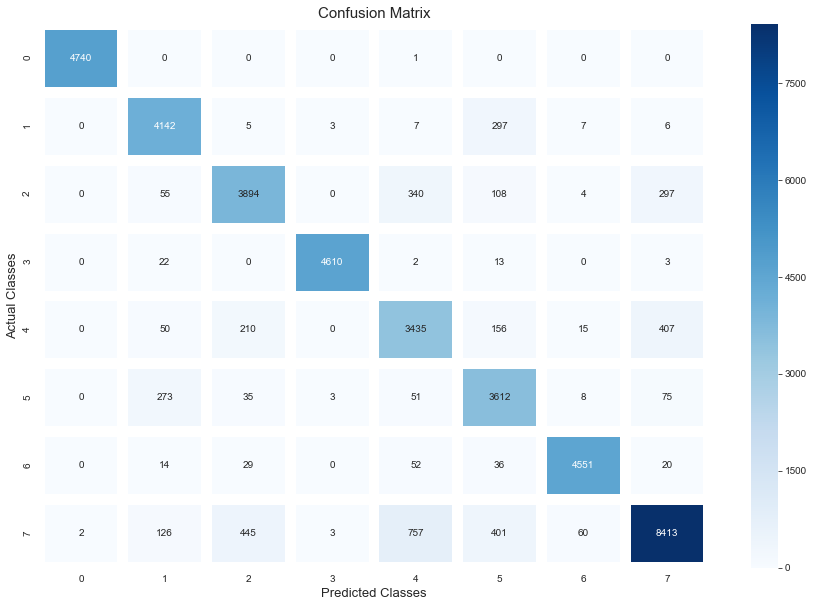

In [494]:
cnf_matrix = confusion_matrix(predictions_3, y_test)

plt.figure(figsize=(15,10))
sns.heatmap(cnf_matrix, annot = True, fmt = 'd', cmap= 'Blues', linewidths=10, )
plt.title('Confusion Matrix', size= 15)
plt.xlabel('Predicted Classes', size = 13)
plt.ylabel('Actual Classes', size = 13)

plt.show()